# 1. Preperation

In [1]:
import math, time, random, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
device = torch.device("mps")

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

In [4]:
DATASET = "CIFAR10"
DATA_ROOT = "./data"
BATCH_SIZE = 128
NUM_WORKERS = 2

In [5]:
if DATASET == "CIFAR10":
    mean, std = (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
    in_channels, num_classes, input_size = 3, 10, (32, 32)
    train_tfms = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    test_tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    train_set = datasets.CIFAR10(DATA_ROOT, train=True,  download=True, transform=train_tfms)
    test_set  = datasets.CIFAR10(DATA_ROOT, train=False, download=True, transform=test_tfms)
else:
    mean, std = (0.1307,), (0.3081,)
    in_channels, num_classes, input_size = 1, 10, (28, 28)
    train_tfms = transforms.Compose([
        transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    test_tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    train_set = datasets.MNIST(DATA_ROOT, train=True,  download=True, transform=train_tfms)
    test_set  = datasets.MNIST(DATA_ROOT, train=False, download=True, transform=test_tfms)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
len(train_set), len(test_set)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [28]:
def train_one_epoch(model, loader, opt, criterion):
    model.train()
    total_loss, total_acc, tot = 0.0, 0, 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        opt.step()
        tot += x.size(0)
        total_loss += loss.item() * x.size(0)
        total_acc += (logits.argmax(1) == y).sum().item()
    return total_loss / tot, total_acc / tot

In [29]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_acc, tot = 0.0, 0, 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        tot += x.size(0)
        total_loss += loss.item() * x.size(0)
        total_acc += (logits.argmax(1) == y).sum().item()

    return total_loss / tot, total_acc / tot

# 2. ResNet: BasicBlock -> stage -> ResNet18

## 2.1 Basic Block

In [8]:
def conv3x3(cin, cout, stride=1):
    return nn.Conv2d(cin, cout, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(cin, cout, stride=1):
    return nn.Conv2d(cin, cout, kernel_size=1, stride=stride, padding=0, bias=False)

#conv3x3 and conv1x1 coz the kernel_size, padding, they have same H = (H-1)/S + 1 and W = (W-1)/S + 1, where S is stride

In [9]:
class BasicBlock(nn.Module):
    """
    ResNet BasicBlock（用于 ResNet-18/34）
    结构: x -> conv3x3 -> BN -> ReLU -> conv3x3 -> BN -> ( + shortcut ) -> ReLU
    当通道/步幅变化时，使用 1x1 projection 对 x 做对齐。
    """
    expansion = 1 #channel expansion factor
    def __init__(self, cin, cout, stride=1):
        super().__init__()
        self.conv1 = conv3x3(cin, cout, stride) 
        #X: N * Cin * H * W -> N * Cout * H1 * W1 where H1=H W1=W if stride=1, else H1=0.5H, W1=0.5W if stride=2
        self.bn1 = nn.BatchNorm2d(cout)
        #batchnorm keep the shape: N * Cout * H1 * W1
        self.conv2 = conv3x3(cout, cout, 1)
        #stride=1, so keep shape N * Cout * H1 * W1
        self.bn2 = nn.BatchNorm2d(cout)
        #betchnorm keep the shape: N * Cout * H1 * W2

        #dimension matching x and output for skip connection
        #to match cout and H/W
        if stride != 1 or cin != cout * self.expansion:
            self.shortcut = nn.Sequential(
                conv1x1(cin, cout * self.expansion, stride),
                nn.BatchNorm2d(cout * self.expansion)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x)
        out = F.relu(out, inplace=True)
        return out

## 2.2 make stage: stacking multiple block

the first will downsampling

In [16]:
def make_stage(block_cls, cin, cout, num_blocks, stride_first):
    layers = []
    layers.append(block_cls(cin, cout, stride=stride_first)) #the first stride could be 2 to downsampling
    for _ in range(1, num_blocks):
        layers.append(block_cls(cout * block_cls.expansion, cout, stride=1))
    return nn.Sequential(*layers), cout * block_cls.expansion

## 2.3 ResNet-18

In [17]:
class ResNet18(nn.Module):
    def __init__(self, in_ch=3, num_classes=10):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, 64, 3, stride=1, padding=1, bias=False), #input [N,3,32,32] -> after conv2d: [N, 64, 32, 32]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        c = 64
        self.layer1, c = make_stage(BasicBlock, c, 64, num_blocks=2, stride_first=1) #[N, 64, 32, 32]
        self.layer2, c = make_stage(BasicBlock, c, 128, num_blocks=2, stride_first=2) #downsampling [N, 128, 16, 16]
        self.layer3, c = make_stage(BasicBlock, c, 256, num_blocks=2, stride_first=2) #[N, 256, 8, 8]
        self.layer4, c = make_stage(BasicBlock, c, 512, num_blocks=2, stride_first=2) #[N, 512, 4, 4]
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), #adaptive pool to [N1 512, 1, 1]
            nn.Flatten(),
            nn.Linear(512 * BasicBlock.expansion, num_classes)
        )

        #initialize
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.head(x)
        return x

# 3. PlainCNN (no skip)

## 3.1 Plain CNN block

与 BasicBlock 同样的参数量配置，但去掉 skip，从而对比“无跳连接”的深网络。
    结构：x -> conv3x3 -> BN -> ReLU -> conv3x3 -> BN -> ReLU

In [18]:
class PlainBlock(nn.Module):
    def __init__(self, cin, cout, stride=1):
        super().__init__()
        self.body = nn.Sequential(
            conv3x3(cin, cout, stride),
            nn.BatchNorm2d(cout),
            nn.ReLU(inplace=True),
            conv3x3(cout, cout, 1),
            nn.BatchNorm2d(cout),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.body(x)

## 3.2 Make plain layer (seudo-stage)

In [19]:
def make_stage_plain(cin, cout, num_blocks, stride_first):
    layers = []
    layers.append(PlainBlock(cin, cout, stride=stride_first))
    for _ in range(1, num_blocks):
        layers.append(PlainBlock(cout, cout, stride=1))
    return nn.Sequential(*layers), cout

## 3.3 Plain CNN deep

深层 PlainCNN：结构与 ResNet18 的 stage 对齐，但每个 block 不做跳连接。
    便于公平比较“是否有 skip”对训练稳定性和泛化的影响。

In [26]:
class PlainCNN(nn.Module):
    def __init__(self, in_ch=3, num_classes=10):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        c = 64
        self.layer1, c = make_stage_plain(c,  64, num_blocks=2, stride_first=1)
        self.layer2, c = make_stage_plain(c, 128, num_blocks=2, stride_first=2)
        self.layer3, c = make_stage_plain(c, 256, num_blocks=2, stride_first=2)
        self.layer4, c = make_stage_plain(c, 512, num_blocks=2, stride_first=2)
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )
        #initialize
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.head(x)
        return x

# 4. Compare ResNet-18 vs. PlainCNN

In [30]:
def compare_models(epochs=10, lr=1e-3, wd=1e-4):
    resnet = ResNet18(in_ch=3, num_classes=10).to(device)
    plain  = PlainCNN(in_ch=3,  num_classes=10).to(device)
    opt_r = torch.optim.AdamW(resnet.parameters(), lr=lr, weight_decay=wd)
    opt_p = torch.optim.AdamW(plain.parameters(),  lr=lr, weight_decay=wd)
    crit = nn.CrossEntropyLoss()

    hist = {"res_train_acc":[], "res_test_acc":[], "pln_train_acc":[], "pln_test_acc":[]}

    for ep in range(1, epochs+1):
        trL_r, trA_r = train_one_epoch(resnet, train_loader, opt_r, crit)
        teL_r, teA_r = evaluate(resnet, test_loader, crit)
        trL_p, trA_p = train_one_epoch(plain,  train_loader, opt_p, crit)
        teL_p, teA_p = evaluate(plain,  test_loader, crit)
        hist["res_train_acc"].append(trA_r); hist["res_test_acc"].append(teA_r)
        hist["pln_train_acc"].append(trA_p); hist["pln_test_acc"].append(teA_p)
        print(f"[ResNet ] ep{ep:02d} train_acc={trA_r:.3f} test_acc={teA_r:.3f}")
        print(f"[Plain  ] ep{ep:02d} train_acc={trA_p:.3f} test_acc={teA_p:.3f}")
    return resnet, plain, hist

resnet, plain, hist = compare_models(epochs=12, lr=1e-3, wd=1e-4)

[ResNet ] ep01 train_acc=0.498 test_acc=0.608
[Plain  ] ep01 train_acc=0.446 test_acc=0.520
[ResNet ] ep02 train_acc=0.686 test_acc=0.685
[Plain  ] ep02 train_acc=0.624 test_acc=0.625
[ResNet ] ep03 train_acc=0.760 test_acc=0.755
[Plain  ] ep03 train_acc=0.704 test_acc=0.679
[ResNet ] ep04 train_acc=0.801 test_acc=0.777
[Plain  ] ep04 train_acc=0.753 test_acc=0.766
[ResNet ] ep05 train_acc=0.827 test_acc=0.772
[Plain  ] ep05 train_acc=0.789 test_acc=0.795
[ResNet ] ep06 train_acc=0.845 test_acc=0.772
[Plain  ] ep06 train_acc=0.815 test_acc=0.799
[ResNet ] ep07 train_acc=0.861 test_acc=0.840
[Plain  ] ep07 train_acc=0.831 test_acc=0.807
[ResNet ] ep08 train_acc=0.877 test_acc=0.836
[Plain  ] ep08 train_acc=0.845 test_acc=0.807
[ResNet ] ep09 train_acc=0.885 test_acc=0.859
[Plain  ] ep09 train_acc=0.859 test_acc=0.853
[ResNet ] ep10 train_acc=0.893 test_acc=0.859
[Plain  ] ep10 train_acc=0.867 test_acc=0.829
[ResNet ] ep11 train_acc=0.899 test_acc=0.846
[Plain  ] ep11 train_acc=0.878 tes

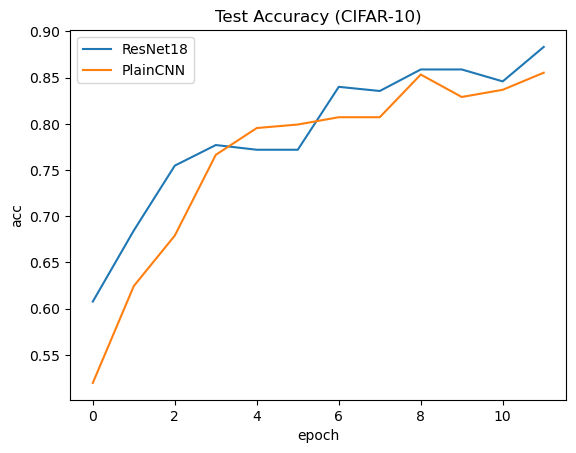

In [31]:
import matplotlib.pyplot as plt
plt.figure(); plt.plot(hist["res_test_acc"], label="ResNet18"); plt.plot(hist["pln_test_acc"], label="PlainCNN"); 
plt.title("Test Accuracy (CIFAR-10)"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend(); plt.show()

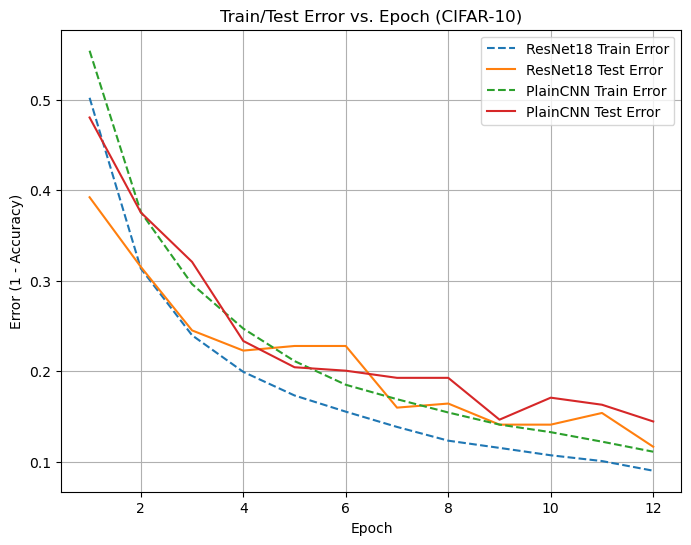

In [32]:
epochs = range(1, len(hist["res_train_acc"]) + 1)

plt.figure(figsize=(8,6))

# ResNet18
plt.plot(epochs, 1 - np.array(hist["res_train_acc"]), label="ResNet18 Train Error", linestyle="--")
plt.plot(epochs, 1 - np.array(hist["res_test_acc"]), label="ResNet18 Test Error", linestyle="-")

# PlainCNN
plt.plot(epochs, 1 - np.array(hist["pln_train_acc"]), label="PlainCNN Train Error", linestyle="--")
plt.plot(epochs, 1 - np.array(hist["pln_test_acc"]), label="PlainCNN Test Error", linestyle="-")

plt.title("Train/Test Error vs. Epoch (CIFAR-10)")
plt.xlabel("Epoch")
plt.ylabel("Error (1 - Accuracy)")
plt.legend()
plt.grid(True)
plt.show()